In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [7]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),       
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),   
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [8]:
def potential(x,k,l,scale=100):
    # poten=-1/x*scale
    # return poten-k*(l+1)*l/x**2
    
    poten=-18/x-10*torch.sin(torch.pi*x/12)/x
    return poten

In [9]:
def energy(en_level,l,k,scale,device,dtype):
    en_list=[scale**2/(4*k*(i+1)**2) for i in range(en_level)]
    en_list=torch.tensor(en_list,device=device,dtype=dtype)
    return en_list

In [10]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:9" if torch.cuda.is_available() else "cpu")

La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0
# 控制势函数的大小
scale=10

en_num=30
extend_num=10
epoch=200000
lr=0.01


In [11]:
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_diag=potential(grid,b_lap,l,scale)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)

real_en=eigenvalues[:en_num].detach()
print('initial eigenvalues check:')
print(eigenvalues[:en_num+extend_num])

initial eigenvalues check:
tensor([-1.5716e+02, -4.2614e+01, -2.0499e+01, -1.2652e+01, -8.9446e+00,
        -6.8350e+00, -5.4473e+00, -4.4245e+00, -3.6072e+00, -2.9203e+00,
        -2.3266e+00, -1.8068e+00, -1.3519e+00, -9.5972e-01, -8.8332e-01,
        -7.4324e-01, -6.3628e-01, -6.1359e-01, -4.9857e-01, -4.6821e-01,
        -4.2221e-01, -3.7320e-01, -3.6546e-01, -3.1555e-01, -2.9309e-01,
        -2.7352e-01, -2.3183e-01, -2.1964e-01, -1.9558e-01, -1.6086e-01,
        -1.5237e-01, -1.3085e-01, -1.2296e-01, -1.0179e-01, -7.9435e-02,
        -5.6185e-02, -3.5326e-02, -1.0974e-02,  1.4396e-02,  4.2974e-02],
       device='cuda:9')


In [12]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=50,threshold=1e-4)
loss_fn=nn.L1Loss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    '''output=NN(input)
    diag=torch.diag(output.flatten())'''
    
    output=eigenvalues[:en_num]
    loss=loss_fn(output/real_en,real_en/real_en)/10+loss_fn(output,real_en)
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
        print('\nepoch:',i)
        print(eigenvalues[:en_num+extend_num])
        print(real_en)
    
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
    
final_loss=loss.item()
final_time=time.time()-init_time
final_epoch=i+1
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')


epoch:0,loss:9.756397247314453,time:0.24319028854370117,lr:0.01

epoch: 0
tensor([0.1006, 0.1106, 0.1401, 0.1443, 0.1628, 0.1791, 0.1815, 0.1990, 0.2006,
        0.2085, 0.2163, 0.2279, 0.2385, 0.2505, 0.2644, 0.2793, 0.2950, 0.3125,
        0.3301, 0.3493, 0.3696, 0.3902, 0.4125, 0.4354, 0.4595, 0.4845, 0.5106,
        0.5377, 0.5657, 0.5948, 0.6250, 0.6553, 0.6876, 0.7207, 0.7546, 0.7895,
        0.8254, 0.8624, 0.9011, 0.9395], device='cuda:9',
       grad_fn=<SliceBackward0>)
tensor([-157.1582,  -42.6144,  -20.4988,  -12.6519,   -8.9446,   -6.8350,
          -5.4473,   -4.4245,   -3.6072,   -2.9203,   -2.3266,   -1.8068,
          -1.3519,   -0.9597,   -0.8833,   -0.7432,   -0.6363,   -0.6136,
          -0.4986,   -0.4682,   -0.4222,   -0.3732,   -0.3655,   -0.3156,
          -0.2931,   -0.2735,   -0.2318,   -0.2196,   -0.1956,   -0.1609],
       device='cuda:9')
epoch:10,loss:9.36053466796875,time:1.2954614162445068,lr:0.01

epoch: 10
tensor([-4.5673, -4.3988, -4.2608, -4.1388, -4

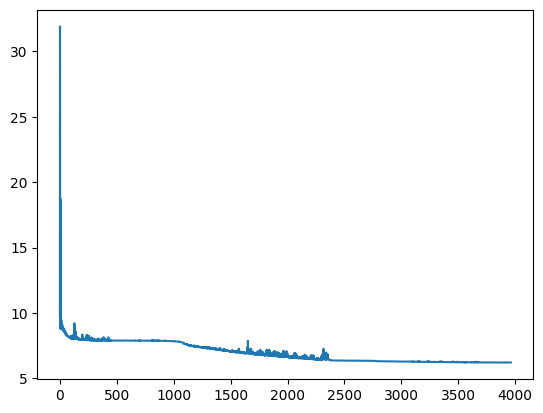

In [13]:
plt.plot(loss_list)
plt.show()

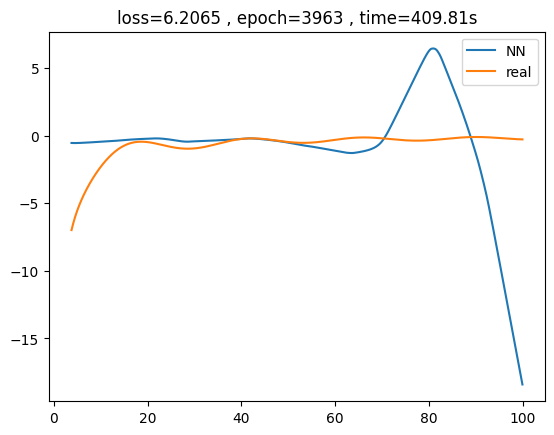

In [14]:
La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[150:]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,l,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()


In [15]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_diag=model(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
output=eigenvalues[:en_num]

error=output-real_en
rela_error=error/real_en
print('final error:',error)
print('relative error:',rela_error)

final error: tensor([ 1.4150e+02,  2.9052e+01,  8.6532e+00,  2.3225e+00, -1.2970e-04,
        -8.2191e-01, -9.9929e-01, -8.7968e-01, -6.2122e-01, -3.0544e-01,
         3.0893e-02,  3.8149e-01,  1.7179e-01, -5.5071e-02,  5.8857e-03,
        -8.8285e-03,  1.6630e-05, -7.8064e-04, -2.5502e-02,  1.0642e-04,
         7.4959e-03, -2.8700e-05, -7.6476e-04, -6.0260e-05, -1.7971e-05,
        -5.3346e-06,  2.1778e-04,  1.0073e-05,  8.2493e-05, -2.5277e-03],
       device='cuda:9', grad_fn=<SubBackward0>)
relative error: tensor([-9.0036e-01, -6.8175e-01, -4.2213e-01, -1.8356e-01,  1.4500e-05,
         1.2025e-01,  1.8345e-01,  1.9882e-01,  1.7222e-01,  1.0459e-01,
        -1.3279e-02, -2.1113e-01, -1.2707e-01,  5.7382e-02, -6.6631e-03,
         1.1878e-02, -2.6136e-05,  1.2723e-03,  5.1150e-02, -2.2730e-04,
        -1.7754e-02,  7.6901e-05,  2.0926e-03,  1.9097e-04,  6.1316e-05,
         1.9504e-05, -9.3940e-04, -4.5862e-05, -4.2178e-04,  1.5714e-02],
       device='cuda:9', grad_fn=<DivBackward0

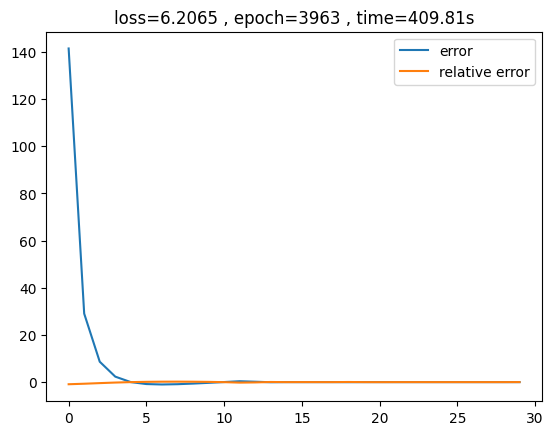

In [16]:

plt.plot(error.detach().cpu().numpy(),label='error')
plt.plot(rela_error.detach().cpu().numpy(),label='relative error')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()
